# Tabular Playground Series - Feb 2022 and simple MLP

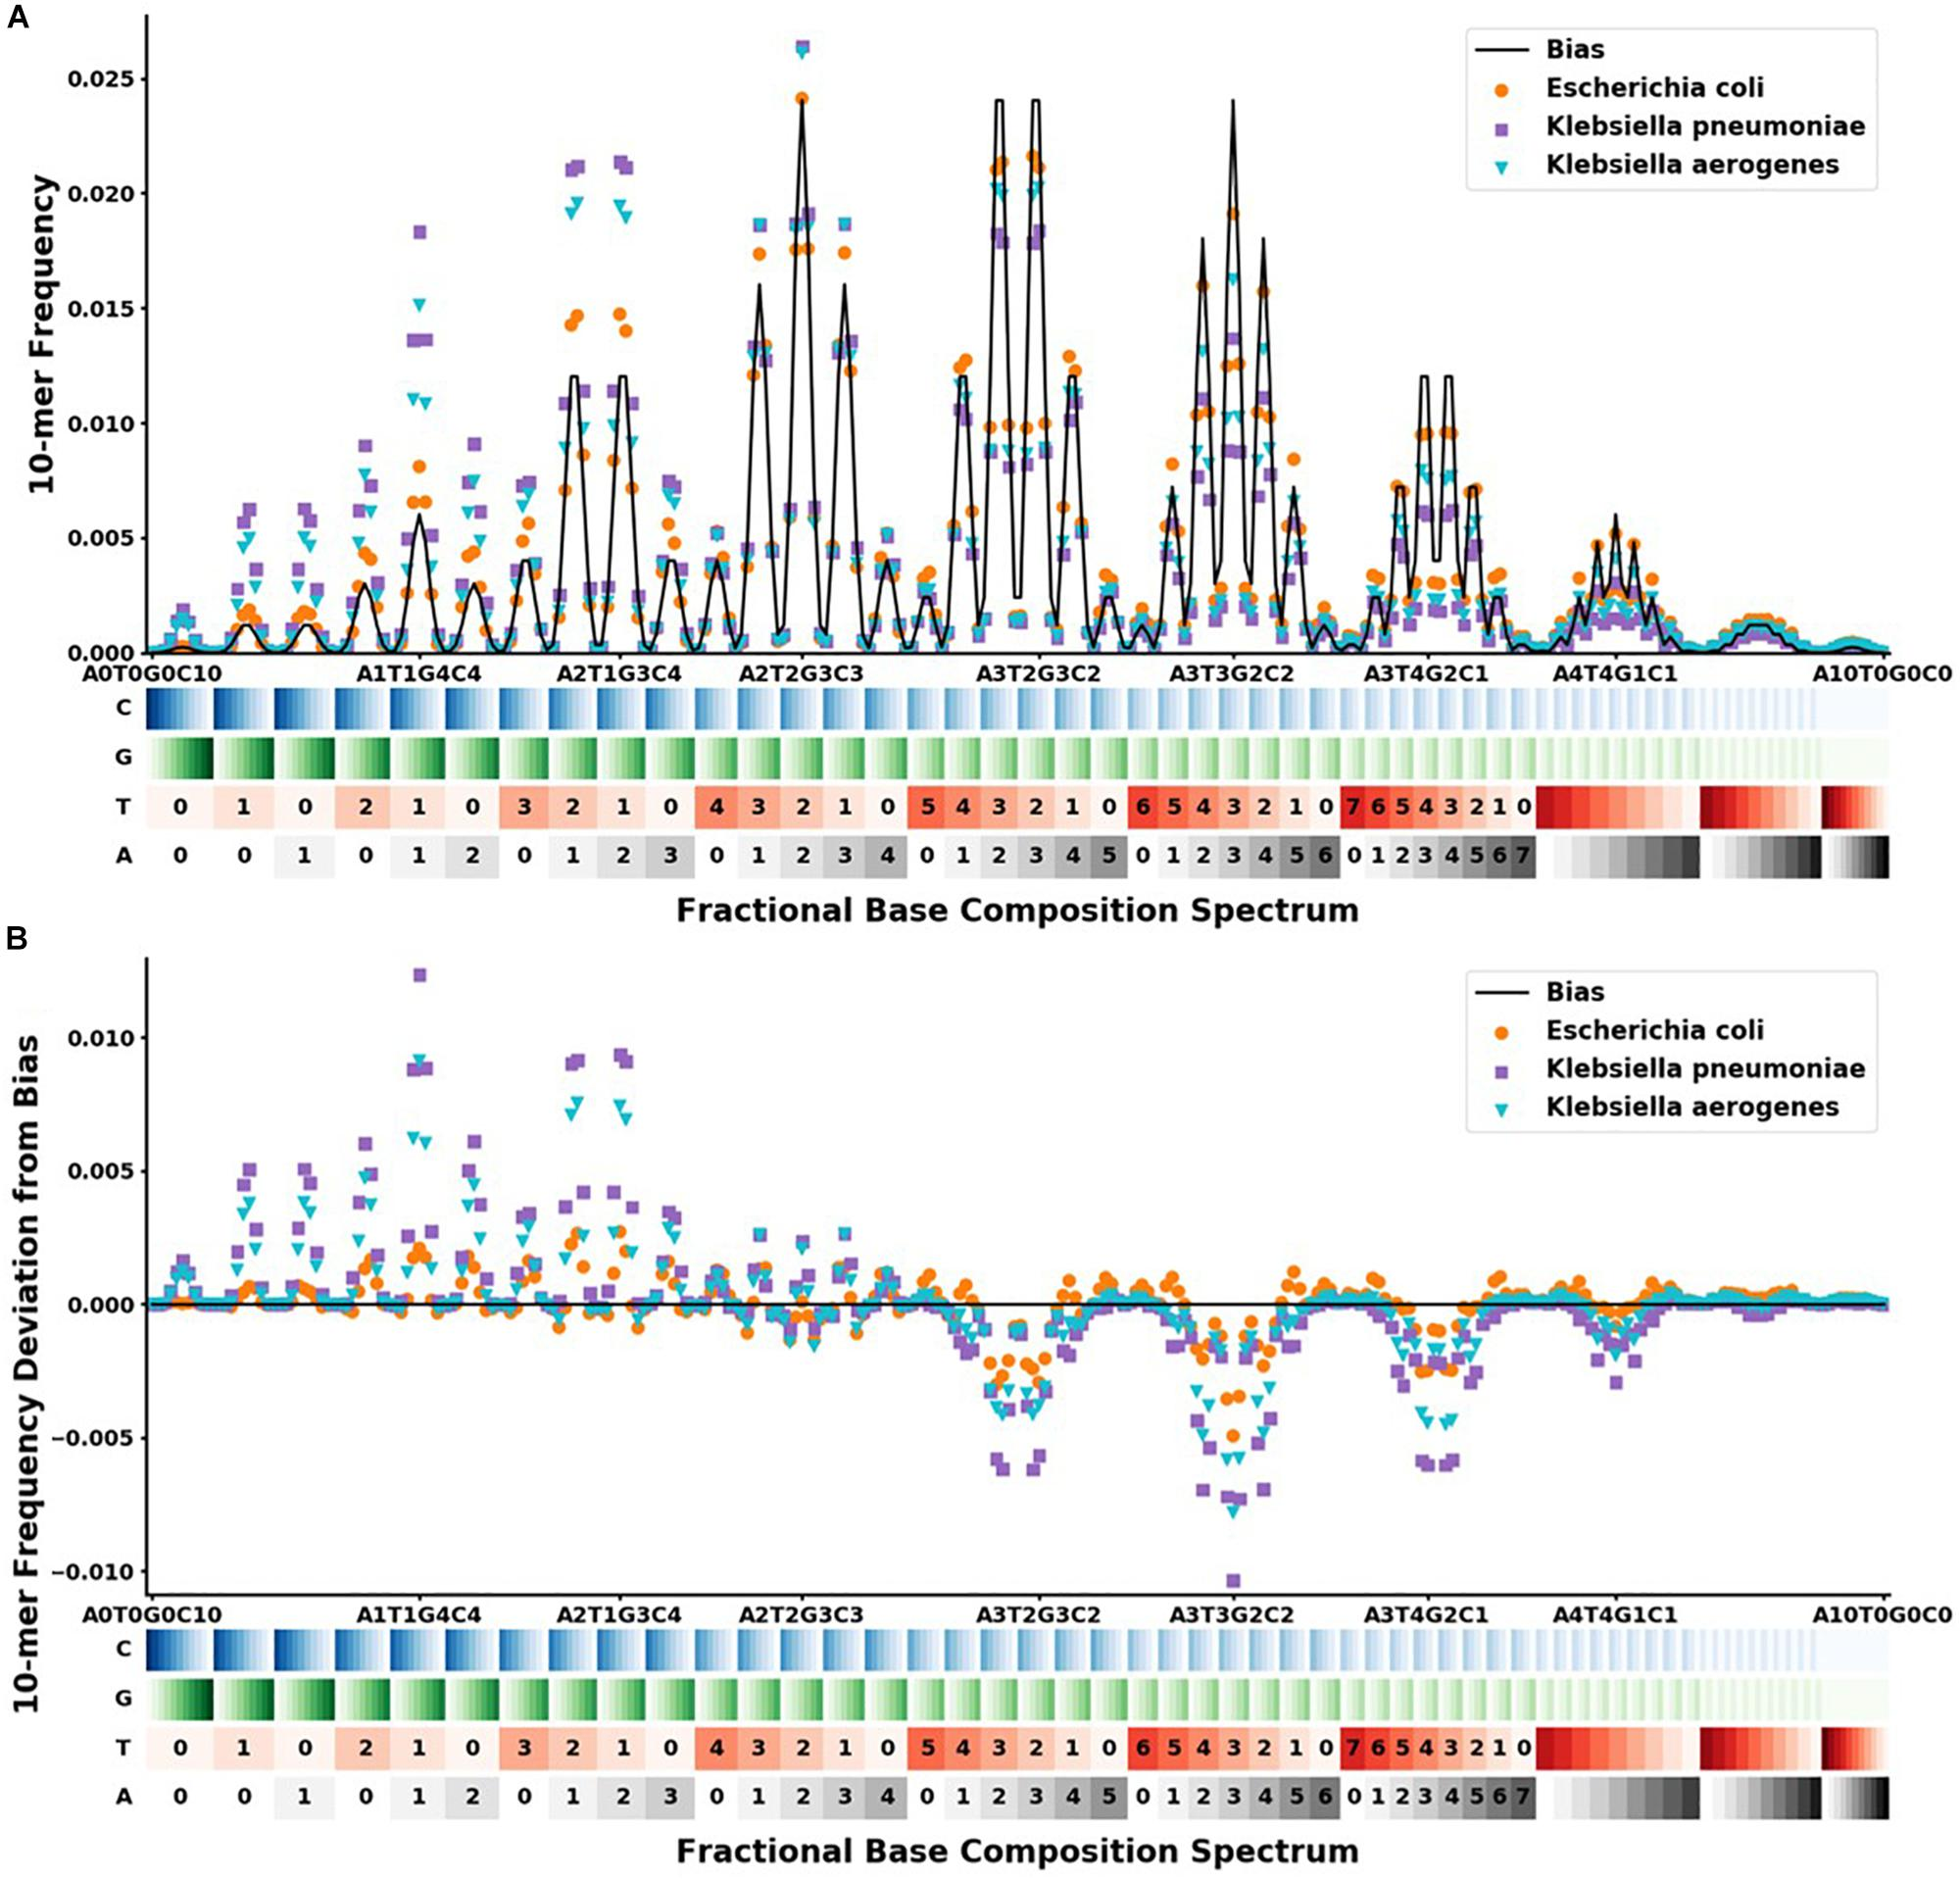

This project is based on the Tabular Playground Series - Feb 2022 from <a href="https://www.kaggle.com/competitions/tabular-playground-series-feb-2022/overview" target="_blank">Kaggle</a>, which is based on data from original research article <a href="https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full" target="_blank">hyper"Analysis of Identification Method for Bacterial Species and Antibiotic Resistance Genes Using Optical Data From DNA Oligomers"</a>. 

The targets of this work are formulated at the beginning of the article above.

`Bacterial antibiotic resistance is becoming a significant health threat, and rapid identification of antibiotic-resistant bacteria is essential to save lives and reduce the spread of antibiotic resistance. This paper analyzes the ability of machine learning algorithms (MLAs) to process data from a novel spectroscopic diagnostic device to identify antibiotic-resistant genes and bacterial species by comparison to available bacterial DNA sequences. Simulation results show that the algorithms attain from 92% accuracy (for genes) up to 99% accuracy (for species). This novel approach identifies genes and species by optically reading the percentage of A, C, G, T bases in 1000s of short 10-base DNA oligomers instead of relying on conventional DNA sequencing in which the sequence of bases in long oligomers provides genetic information. The identification algorithms are robust in the presence of simulated random genetic mutations and simulated random experimental errors. Thus, these algorithms can be used to identify bacterial species, to reveal antibiotic resistance genes, and to perform other genomic analyses. Some MLAs evaluated here are shown to be better than others at accurate gene identification and avoidance of false negative identification of antibiotic resistance.`

Let's begin. Load required modules.

In [1]:
from IPython.display import display
from IPython.display import HTML

from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

import copy
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd 
import re
import seaborn as sns
import time
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')  

from tensorflow import keras

from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

pd.options.display.max_columns = 300
pd.options.display.max_rows = 300

2022-05-07 19:53:08.160540: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## 1. Exploratory Data Analyst

### 1.1. Load analyze and prepare data - remove duplicates and coding target (y) with OneHotEncoder:

In [2]:
%%time
# Open datasets link for download bellow
# https://www.kaggle.com/competitions/tabular-playground-series-feb-2022/data
train_raw = pd.read_csv("/home/mvg/Documents/Ewps/ML_DL/DL/TPS_022022/data/train.csv")
test_raw = pd.read_csv("/home/mvg/Documents/Ewps/ML_DL/DL/TPS_022022/data/test.csv")
submission_raw = pd.read_csv("/home/mvg/Documents/Ewps/ML_DL/DL/TPS_022022/data/sample_submission.csv")
train_raw.set_index("row_id", inplace=True)
test_raw.set_index("row_id", inplace=True)
# Check nan values
print("The train has {} features with nan values."\
      .format(list(train_raw.isnull().sum().values > 0).count(True)))
print("The test has {} features with nan values."\
      .format(list(test_raw.isnull().sum().values > 0).count(True)))
print("The sample_submission has with  {} features nan values."\
      .format(list(submission_raw.isnull().sum().values > 0).count(True)))
# Exploraratory data analyst
# Check duplicates
train_duplicated_rows = train_raw[train_raw.duplicated()==True].shape[0]
print("\ntrain dataset contains {:,} rows from total {:,} rows.\
Share duplicates = {:.2f}%".format(train_duplicated_rows,
                                  train_raw.shape[0],
                                  100.0*train_duplicated_rows/train_raw.shape[0]))
test_duplicated_rows = test_raw[test_raw.duplicated()==True].shape[0]
print("\ntest dataset contains {:,} rows from total {:,} rows.\
Share duplicates = {:.2f}%".format(test_duplicated_rows,
                                  test_raw.shape[0],
                                  100.0*test_duplicated_rows/test_raw.shape[0]))
# Remove duplicates from train and test datasets
train = train_raw.drop_duplicates() 
test = test_raw.drop_duplicates() 
# Check y range and  dispersion - the uniform distribution
train_target_dispersion = train.target.value_counts(normalize=True)*100
print(train_target_dispersion)
print("\nTotal classes for target :{:}.".format(len(train_target_dispersion.values)))
# Encode target one hot encoder and separate to X and Y
train_x_all = train.iloc[:,:-1].values
train_y_all = train.iloc[:,[-1]].values
test_x_all = test.values
ohe = OneHotEncoder()
ohe.fit(train_y_all)
train_y_all_ohe = ohe.transform(train_y_all).toarray()

The train has 0 features with nan values.
The test has 0 features with nan values.
The sample_submission has with  0 features nan values.

train dataset contains 76,007 rows from total 200,000 rows.Share duplicates = 38.00%

test dataset contains 26,779 rows from total 100,000 rows.Share duplicates = 26.78%
Bacteroides_fragilis        10.098957
Campylobacter_jejuni        10.056213
Klebsiella_pneumoniae       10.016694
Streptococcus_pneumoniae    10.013469
Staphylococcus_aureus       10.012662
Streptococcus_pyogenes      10.005404
Salmonella_enterica          9.992500
Enterococcus_hirae           9.978789
Escherichia_coli             9.917495
Escherichia_fergusonii       9.907817
Name: target, dtype: float64

Total classes for target :10.
CPU times: user 28.3 s, sys: 2.61 s, total: 30.9 s
Wall time: 30.9 s


Define scaling function  for further using.

In [3]:
%%time
# Scaler for array
def npscaler(x_values, scaler="ss"):
    """
    Scale/transform np array. 
    Possible scale/transform option for x features:
    1. None – not scale or trainsform
    2. “ptbc”   Power-transformer by Box-Cox
    3. “ptbc” - .PowerTransformer by Yeo-Johnson’
    4. “rb” - .RobustScaler(
    5. "ss" - StandardScaler    
    For prevent data leakage using separate instance scaler/transformer 
    for each train and test parts.
    Parameters
    ----------
        x_values :np.array with numeric values of features.
        scaler : TYPE - None or str, optional.  The default is None.
    Returns
    -------
        x_vals - scaled/transformed np.array
    """
    scalers = ["ptbc", "ptyj", "rb", "ss"]
    x_vals = np.copy(x_values)
    mms = MinMaxScaler(feature_range=(1, 2))
    ptbc = PowerTransformer(method='box-cox')
    ptyj = PowerTransformer()
    rb = RobustScaler(unit_variance=True)
    ss = StandardScaler()
        
    if scaler == "ptbc":
        x_vals = ptbc.fit_transform(mms.fit_transform(x_vals[:,:]))
                         
    elif scaler == "ptyj":
        x_vals = ptyj.fit_transform(x_vals[:,:])
    
    elif scaler == "rb":
        x_vals = rb.fit_transform(x_vals[:,:]), \
    
    elif scaler == "ss":
        x_vals =  ss.fit_transform(x_vals[:,:])
        
    if scaler not in scalers:
        return "Value error for 'scaler'!Enter \
'ptbc' or", " 'ptyj' or 'rb' or 'ss' value for scaler!"
    return x_vals

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


### 1.2 Find input and output biases

In [4]:
%%time
# Find out put bias vector for y - divide pos==1 to neg==0
output_bias = []
for i in range (train_y_all_ohe.shape[1]):
    neg, pos = np.bincount(train_y_all_ohe[:,0].astype(int))/train_y_all_ohe[:,0].shape[0]
    output_bias.append(np.log(pos/neg))
output_bias = np.array(output_bias)



# Find input bias  for Standard Scaler  using this link
# https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full

train_features = list(train.columns)[:-1]
input_bias=[]
reg_a = (r"(A\d+)")
reg_t = (r"(T\d+)")
reg_g = (r"(G\d+)")
reg_c = (r"(C\d+)")
for name in train_features:
    int_a = int(re.findall(reg_a, name)[0].replace("A",""))
    int_t = int(re.findall(reg_t, name)[0].replace("T",""))
    int_g = int(re.findall(reg_g, name)[0].replace("G",""))
    int_c = int(re.findall(reg_c, name)[0].replace("C",""))
    bias = ((1/4)**10) * math.factorial(10)/(math.factorial(int_a)
                                          * math.factorial(int_t)
                                          * math.factorial(int_g)
                                          * math.factorial(int_c))
    input_bias.append(bias)

# 1. Scale input bias with standard scaler and extract
train_x_all_with_bias = np.append(np.array(input_bias).reshape(1,-1),
                                       train_x_all, axis=0)
train_x_all_with_bias_ss = npscaler(train_x_all_with_bias)
input_bias_ss = train_x_all_with_bias_ss[-1,:]

CPU times: user 660 ms, sys: 223 ms, total: 883 ms
Wall time: 878 ms


### 1.3 Estimate values of  PCA components for train and test datasets

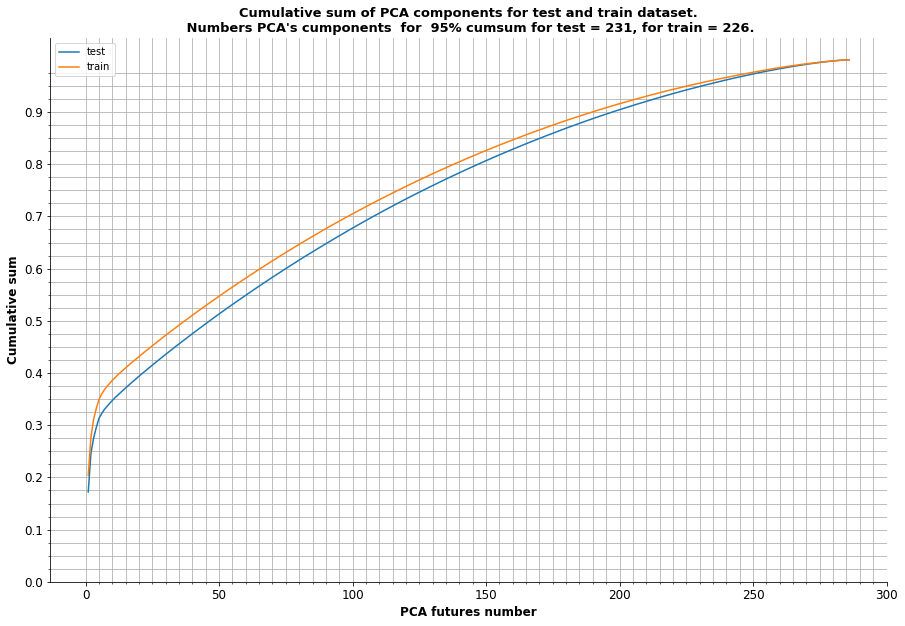

CPU times: user 1min 10s, sys: 9.57 s, total: 1min 20s
Wall time: 12.9 s


In [5]:
%%time
# PCA analysis for train dataset
pca_train=PCA()
pca_train.fit(npscaler(train_x_all))
pca_train_cumsum = np.cumsum(pca_train.explained_variance_ratio_)
pca_train_comp_no = np.array(list(range(1,len(pca_train_cumsum)+1)))
# define number of components with 95% variance
pca_train_comp = np.argmax(pca_train_cumsum >= 0.95) + 1
pca_train_df = pd.DataFrame(data=pca_train_cumsum , 
                           columns=["pca_var_ratio"])

# Check PCA for test dataset
pca_test=PCA()
pca_test.fit(npscaler(test_x_all))
pca_test_cumsum = np.cumsum(pca_test.explained_variance_ratio_)
pca_test_comp_no = np.array(list(range(1,len(pca_test_cumsum)+1)))
# define number of components with 95$ variance
pca_test_comp = np.argmax(pca_test_cumsum >= 0.95) + 1
pca_test_df = pd.DataFrame(data=pca_test_cumsum , 
                           columns=["pca_var_ratio"])

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(pca_test_comp_no, pca_test_cumsum, label="test")
ax.plot(pca_train_comp_no, pca_train_cumsum, label="train")
ax.legend()
# Set major sticks
major_xticks = np.arange(0,len(pca_train_comp_no)+15, 50)
major_yticks = np.arange(0,1.0, 0.1)

# Set minor sticks
minor_xticks = np.arange(0,len(pca_train_comp_no)+15, 5)
minor_yticks = np.arange(0,1.0, 0.025)

# Define major and minor sticks
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)

ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor = True)

ax.set_yticks(major_yticks);
ax.set_yticks(minor_yticks, minor = True);

ax.grid(visible=True, which="both", axis="both")

# ax labels
ax.set_ylabel('Cumulative sum', fontsize=12, fontweight="bold")
ax.set_xlabel("PCA futures number", fontsize=12, fontweight="bold")
ax.legend()
ax.set_title("Cumulative sum of PCA components for test and train dataset.\
\n Numbers PCA's cumponents  for  95% cumsum for test = {:}, for train = {:}.".format(
    pca_test_comp, pca_train_comp),
             fontsize=13,
             fontweight="bold")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

As see above 95% of cumulative sum of variance ratio for train dataset equal 226 features, but for test dataset equal 231. Remain last value for further using and apply PCA for train and test dataset and calculate input bias for train dataset after PCA conversion.

In [6]:
%%time
# Remain 231 PCA components for PCA and transform it
train_pca=PCA(n_components=231, svd_solver='randomized')

train_pca_x_all=train_pca.fit_transform(npscaler(train_x_all))

# Calculate input_bias for pca, convert with SS for futrher data scaling
train_pca_x_all_with_bias = train_pca.fit_transform(train_x_all_with_bias_ss)
train_pca_x_all_with_bias_ss = npscaler(train_pca_x_all_with_bias) 
input_bias_pca = train_pca_x_all_with_bias_ss[-1,:]

# Convert train with PCA
test_pca=PCA(n_components=231, svd_solver='randomized')
test_pca_x_all=test_pca.fit_transform(npscaler(test_x_all))

CPU times: user 3min 9s, sys: 45.3 s, total: 3min 54s
Wall time: 36.5 s


### 1.4 Estimate mutual information for classifier

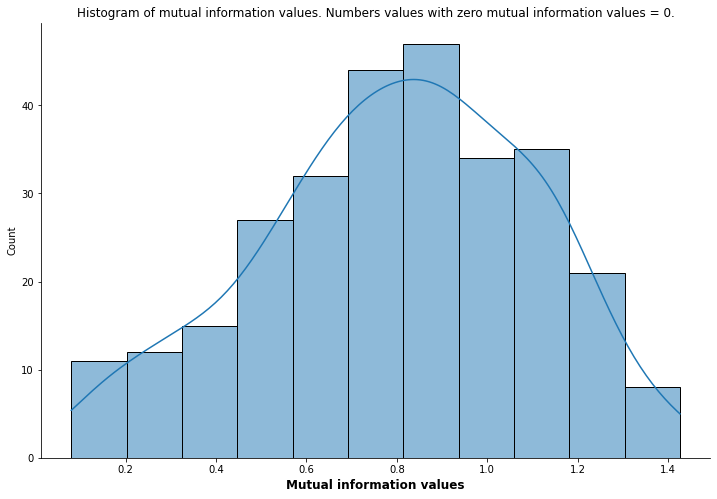

CPU times: user 4min 19s, sys: 469 ms, total: 4min 19s
Wall time: 4min 19s


In [7]:
%%time
mut_inf_clf = mutual_info_classif(train_x_all, train_y_all)
mut_inf_df = pd.DataFrame(data=list(train.columns)[:-1], columns=['features'])
mut_inf_df["mi_clfs"]=mut_inf_clf
nut_inf_zero_vals = mut_inf_df[mut_inf_df["mi_clfs"]==0].count().values[1] 

# Plot histogram values
fig, ax = plt.subplots(figsize=(12,8))
ax=sns.histplot(data=mut_inf_df, x="mi_clfs", kde=True, ax=ax)
ax.set_title("Histogram of mutual information values. Numbers values with \
zero mutual information values = {}.".format(nut_inf_zero_vals))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Mutual information values", fontsize=12, fontweight="bold")
plt.show()

### 1.5 Preliminary conclusion from EDA

As see above dataset contains 286 features with continuous values and ten targets. PCA variance of features almost evenly distributed. Mutual information for a discrete target variable by features hasn't zero values and have range 0.1 - 1.4.  Classical multilabel classification task for classical Multi Layer Perceptron (MLP).

## 2. Define and normalization model

I spent the huge  of time on the selection of hyperparameters and the optimal network topology. I wrote my own functions for cross validation, tried  use Keras Tuner - but the result was not very good in all cases - these programs worked slowly, did not use multithreading and etc.  In the end, I remembered `Ockham's razor` - `plurality should not be posited without necessity`. Regarding the number of neurons, I used the thumb rule - no more than the number of futures, but the number of layers, I searched with the help of <a href="https://docs.ray.io/en/latest/tune/index.html" target="_blank">Ray Tune</a>. This <a href="https://github.com/Vadim-Maklakov/Data-Science/blob/main/08_Kaggle_Tabular_Playground_Series%20-Feb%202022/tune_tps_02_2022.py" target="_blank">file</a> contains the code for finding the optimal topology, learnrate, Dropout. Execute partially in the IDE with IPython like Spyder. 

## 3. Train and predict

Prepare input and output bias for TF.

In [8]:
%%time
# Convert input and output  biases to to tf constant
tf_output_bias = tf.keras.initializers.Constant(output_bias)
tf_input_bias = tf.keras.initializers.Constant(input_bias_ss)
tf_input_bias_pca = tf.keras.initializers.Constant(input_bias_pca)


CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 13.4 µs


Define model and required functions

In [9]:
def npds_train_test_split(x, y, test_ratio=0.2, batch_sz=512, scaler="ss"):
    """
    Convert, shaffle and scale numpy arrays to tf.data.Dataset.
    Parameters
    ----------
    x : input np.array.
    y : input np.array.
    test_ratio : float, optional, the default is 0.2.
        Ratio for test part to all array  rows. If None return all 
        tf.data.Dataset.
    batch_sz : int, optional. The default is 1024.
        batch size
    scaler : string, optional. The default is "ss".
    Returns
    -------
    tf.data.Dataset.
    """

    if test_ratio != None and test_ratio < 1.0 and isinstance(test_ratio,float):
        x_train, x_test, y_train, y_test = train_test_split(x, y, 
                            test_size=test_ratio, stratify=y,random_state=42)
        x_train, x_test = npscaler(x_train, scaler), npscaler(x_test, scaler)
        ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        ds_train = ds_train.shuffle(buffer_size=x_train.shape[0])\
            .batch(batch_sz).prefetch(1)
        ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
        ds_test = ds_test.shuffle(buffer_size=x_test.shape[0])\
            .batch(batch_sz).prefetch(1)    
        return ds_train, ds_test
    elif test_ratio == None:
        x = npscaler(x)
        ds_all = tf.data.Dataset.from_tensor_slices((x, y))\
            .shuffle(buffer_size=x.shape[0]).batch(batch_sz)
        return ds_all


def clf_adam(shape_x=train_x_all.shape[1], learn_rate=0.005623, 
             drop_out_in=0.35, drop_out_1=0.05, drop_out_2=0.0, drop_out_3=0.1,
             drop_out_4=0.1, input_bias=tf_input_bias, 
             output_bias=tf_output_bias):
    # Define metrics
    metrics_short = [
          tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy")]
    # Create model
    model = Sequential()
    #input layer
    model.add(layers.Dense(units=shape_x, input_shape=(shape_x,),
                           kernel_initializer="GlorotUniform",
                           bias_initializer=input_bias, 
                           activation="relu"))
    model.add(Dropout(rate=drop_out_in))
    model.add(BatchNormalization())
    
    # First hidden layer
    model.add(layers.Dense(units=72, kernel_initializer="GlorotUniform",
                                   activation="relu"))
    model.add(Dropout(rate=drop_out_1))
    model.add(BatchNormalization())
    
    # Second hidden layer
    model.add(layers.Dense(units=72, kernel_initializer="GlorotUniform",
                                   activation="relu"))
    model.add(Dropout(rate=drop_out_2))
    model.add(BatchNormalization())
    
    # Trird layer
    model.add(layers.Dense(units=72, kernel_initializer="GlorotUniform",
                                   activation="relu"))
    model.add(Dropout(rate=drop_out_3))
    model.add(BatchNormalization())
    
    # Fourth layer
    model.add(layers.Dense(units=72, kernel_initializer="GlorotUniform",
                                   activation="relu"))
    model.add(Dropout(rate=drop_out_4))
    model.add(BatchNormalization())
    
    # add final layer
    model.add(layers.Dense(units=10, bias_initializer=output_bias))
    model.add(layers.Activation(activations.softmax))
            
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=learn_rate),
        metrics=metrics_short)
    
    return model


def train_model(model, x_train, y_train_ohe, test_sz=0.2, batch_sz=1024, 
              stop_no=30) :
    callbacks = [EarlyStopping(monitor='categorical_accuracy',mode='max',
                                patience=stop_no,restore_best_weights=True)]

    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train_ohe,
                                                        test_size=test_sz,
                                                        stratify=y_train_ohe,
                                                        random_state=42)
    
    x_train, x_test = npscaler(x_train), npscaler(x_test)
    ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    ds_train = ds_train.shuffle(buffer_size=x_train.shape[0]).batch(batch_sz)\
        .prefetch(1)
    ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    ds_test = ds_test.shuffle(buffer_size=x_test.shape[0]).batch(batch_sz)\
        .prefetch(1)
    ds_start=time.time()
    model_check = copy.copy(model)
    ds_history = model_check.fit(ds_train,
                 epochs=10000,
                 validation_data=ds_test,
                 callbacks=callbacks,
                 verbose=0)
    ds_end=time.time()
    ds_total_time= datetime.timedelta(seconds = (ds_end-ds_start))
    ds_history_df = pd.DataFrame(data=ds_history.history)
    ds_history_df.sort_values(by='val_loss', ascending=True, 
                          inplace=True)
    ds_history_df["epochs"]=ds_history_df.index + 1
    ds_history_df["time"]=ds_total_time
    return model_check, ds_history_df

## 3.1 Train model without PCA

In [10]:
%%time
model_adam, model_adam_hist = train_model(clf_adam(), train_x_all, 
                                          train_y_all_ohe)

2022-05-07 19:58:50.520234: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-07 19:58:50.587829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.5185GHz coreCount: 5 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-05-07 19:58:50.587876: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-07 19:58:50.595003: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-07 19:58:50.595078: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-05-07 19:58:50.596258: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuf

CPU times: user 24min 3s, sys: 2min 27s, total: 26min 31s
Wall time: 15min 3s


CPU times: user 387 ms, sys: 96 ms, total: 483 ms
Wall time: 349 ms


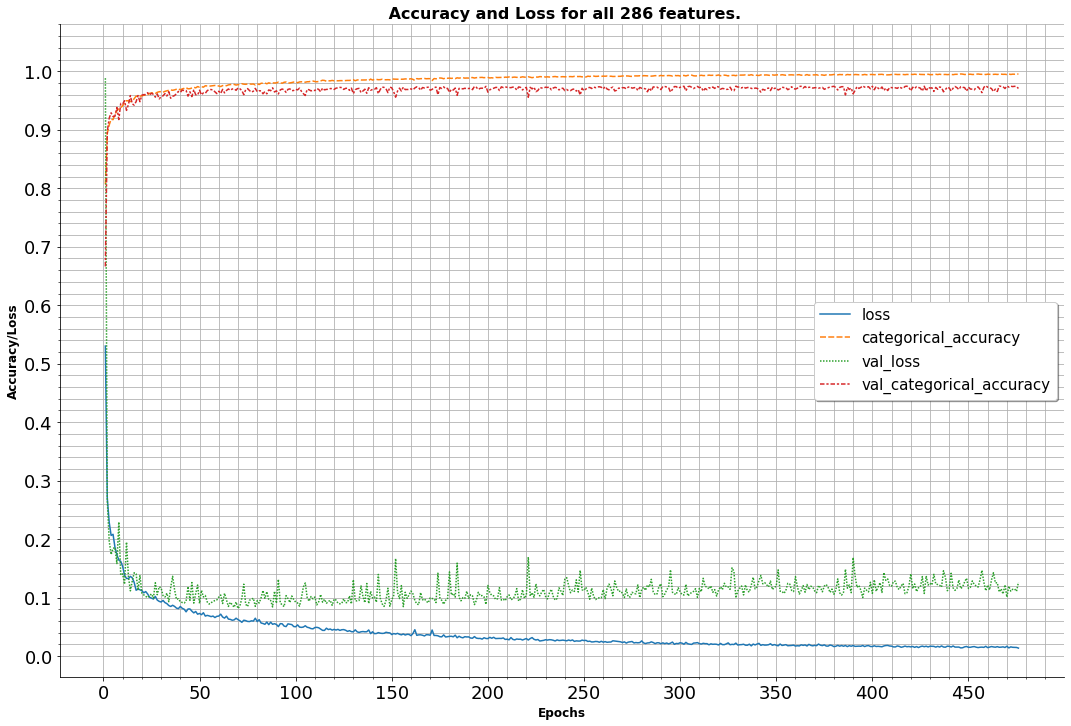

In [11]:
%%time
# Plot accuracy and loss for all 286 features 
fig, ax = plt.subplots(figsize=(18,12))
ax = sns.lineplot(data=model_adam_hist.set_index("epochs"), ax = ax)

ax.set_title(" Accuracy and Loss for all 286 features.", fontsize=16, 
             fontweight="bold")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Set major sticks
major_xticks = np.arange(0,(divmod(model_adam_hist.shape[0], 50)[0]+1)*50, 50)
major_yticks = np.arange(0,1.1, 0.1)

# Set minor sticks
minor_xticks = np.arange(0,(divmod(model_adam_hist.shape[0], 50)[0]+1)*50, 10)
minor_yticks = np.arange(0,1.1, 0.02)

# Define major and minor sticks
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)

ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor = True)

ax.set_yticks(major_yticks);
ax.set_yticks(minor_yticks, minor = True);

ax.grid(visible=True, which="both", axis="both")

# ax labels
ax.set_ylabel('Accuracy/Loss', fontsize=12, fontweight="bold")
ax.set_xlabel("Epochs", fontsize=12, fontweight="bold")
legend = ax.legend(shadow=True, fontsize=15)

Evaluate model

In [12]:
%%time
ds_xy = npds_train_test_split(train_x_all, train_y_all_ohe, batch_sz=32, test_ratio=None)
model_adam_acc = model_adam.evaluate(ds_xy)

3875/3875 [==============================] - 16s 4ms/step - loss: 0.0231 - categorical_accuracy: 0.9948
CPU times: user 25.5 s, sys: 3.48 s, total: 29 s
Wall time: 17.1 s


In [13]:
print("Accuracy model: ",model_adam_acc[1])
print("Loss model: ",model_adam_acc[0])

Accuracy model:  0.9947658181190491
Loss model:  0.023062463849782944


## 3.2 Train model with PCA

In [14]:
%%time
model_adam_pca, model_adam_hist_pca = train_model(clf_adam(
    shape_x=train_pca_x_all.shape[1], input_bias = tf_input_bias_pca),
                                          train_pca_x_all, 
                                          train_y_all_ohe)

CPU times: user 20min 45s, sys: 1min 55s, total: 22min 41s
Wall time: 12min 55s


CPU times: user 357 ms, sys: 106 ms, total: 463 ms
Wall time: 323 ms


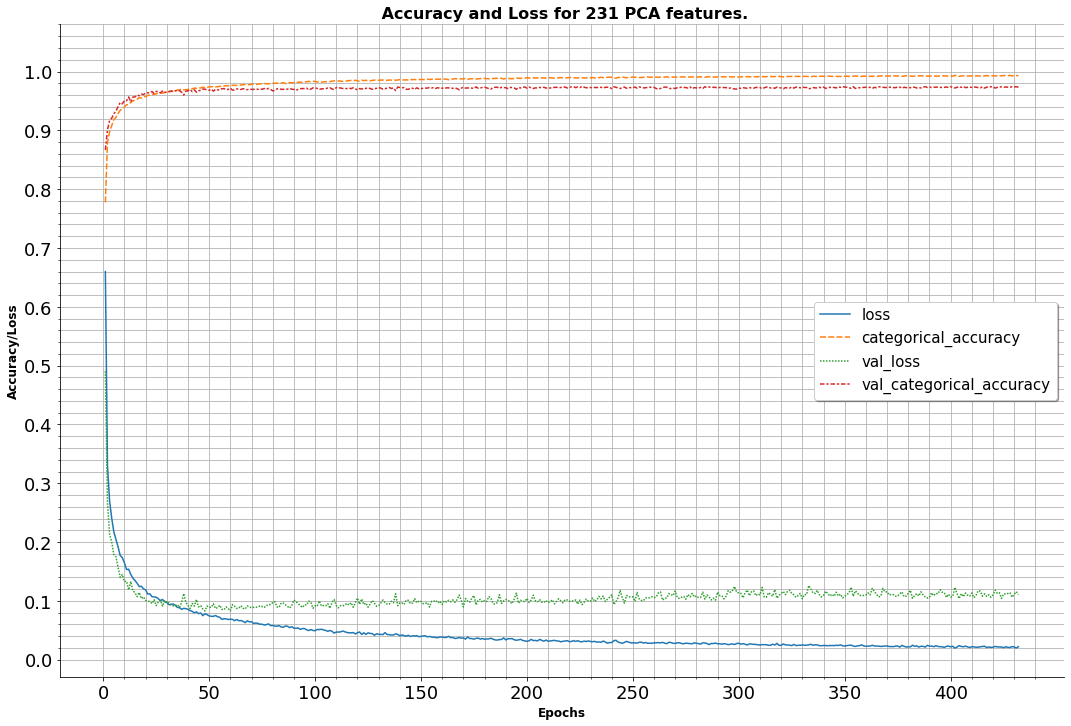

In [15]:
%%time
# Plot accuracy and loss for  231 PCA features 
fig, ax = plt.subplots(figsize=(18,12))
ax = sns.lineplot(data=model_adam_hist_pca.set_index("epochs"), ax = ax)

ax.set_title(" Accuracy and Loss for 231 PCA features.", fontsize=16, 
             fontweight="bold")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Set major sticks
major_xticks = np.arange(0,(divmod(model_adam_hist_pca.shape[0], 50)[0]+1)*50, 50)
major_yticks = np.arange(0,1.1, 0.1)

# Set minor sticks
minor_xticks = np.arange(0,(divmod(model_adam_hist_pca.shape[0], 50)[0]+1)*50, 10)
minor_yticks = np.arange(0,1.1, 0.02)

# Define major and minor sticks
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)

ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor = True)

ax.set_yticks(major_yticks);
ax.set_yticks(minor_yticks, minor = True);

ax.grid(visible=True, which="both", axis="both")

# ax labels
ax.set_ylabel('Accuracy/Loss', fontsize=12, fontweight="bold")
ax.set_xlabel("Epochs", fontsize=12, fontweight="bold")
legend = ax.legend(shadow=True, fontsize=15)

Evaluate PCA model

In [16]:
%%time
ds_pca_xy = npds_train_test_split(train_pca_x_all, train_y_all_ohe, batch_sz=32, 
                                  test_ratio=None)
model_adam_pca_acc = model_adam_pca.evaluate(ds_pca_xy)

3875/3875 [==============================] - 16s 4ms/step - loss: 0.0257 - categorical_accuracy: 0.9942
CPU times: user 24.9 s, sys: 3.27 s, total: 28.2 s
Wall time: 16.8 s


In [17]:
print("Accuracy PCA model: ",model_adam_pca_acc[1])
print("Loss PCA model: ",model_adam_pca_acc[0])

Accuracy PCA model:  0.9941851496696472
Loss PCA model:  0.02573591098189354


View final PCA model:

In [18]:
model_adam_pca.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 231)               53592     
_________________________________________________________________
dropout_5 (Dropout)          (None, 231)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 231)               924       
_________________________________________________________________
dense_7 (Dense)              (None, 72)                16704     
_________________________________________________________________
dropout_6 (Dropout)          (None, 72)                0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 72)                288       
_________________________________________________________________
dense_8 (Dense)              (None, 72)               

## 3.3 Predict values

For predict values I use model with PCA

In [19]:
%%time
y_predict = model_adam_pca.predict(npscaler(test_pca_x_all))

# convert continuous values to binary using argmax
for row in y_predict:
    row = np.where(row < row[np.argmax(row)],0,1)

y_predict_char = ohe.inverse_transform(y_predict)

# Create pandas dataframe submission
test_drop_columns = list(test.columns)
sample_submission = test.drop(labels=test_drop_columns, axis=1)
sample_submission["target"] = y_predict_char
sample_submission.to_csv("/home/mvg/Documents/Ewps/ML_DL/DL/TPS_022022/data/sample_submission_target.csv")
sample_submission.head(10)

CPU times: user 10.8 s, sys: 856 ms, total: 11.7 s
Wall time: 8.19 s


,target
row_id,
200000,Escherichia_fergusonii
200001,Salmonella_enterica
200002,Bacteroides_fragilis
200003,Salmonella_enterica
200004,Staphylococcus_aureus
200005,Escherichia_fergusonii
200006,Salmonella_enterica
200007,Enterococcus_hirae
200008,Streptococcus_pneumoniae


## 4. Conclusion

* 1. Always use Ockham's razor - plurality should not be posited without necessity. In this case of Tabular  continuous values is no need to fence a garden with fifty layers and 50 thousand neurons - it’s just that such a model will take a the huge  time for train and  always quick fall to overfiting and constantly writing in the console error 'Not enough GPU memory' . As see above, the number of neurons equal to the numbers of futures in my case gives a quite acceptable accuracy result of 99.45%.


* 2. The using  of PCA in this case gives a gain in time and accuracy.


* 3. Ray Tune gives excellent results for searching  hyperparameters. Yes it takes 90% of the time but it's worth it.


* 4. As see from plots above  both models converge up to 30 epochs, after 30 epochs begin divergence in both models.


* 5. In principle, it was possible to achieve 100% accuracy, but for this it was necessary to use AdamW, SGDW, learn rate decay and weight decay - my experiments led to the fact that I received a formal reduction the validotion loss from 10% to 6%, but the validation accuracy and accuracy did not increasing. And the selection of optimal values or using  of vanilla SDGs is just a huge time consumption.

Created on May 07, 2022

@author: Vadim Maklakov, used some ideas from public Internet resources.

© 3-clause BSD License

Software environment: Debian 11, Python 3.8.13, TensorFlow 2.5.3, CUDA 11.3 for localhost.

See required installed and imported python modules in the cell No 1.